In [21]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

# The cost of fault tolerance

First we vary journal on/off and cache on/off.

In [11]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for client in data['results']:
                for line in client['stdout_lines']:
                    if "started" in line: start = line.split()[4]
                    if "finished" in line: end = line.split()[4]            
                r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []
    o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

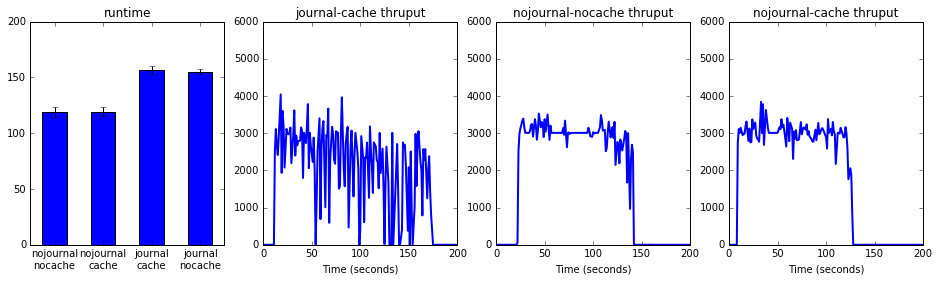

In [12]:
# plot runtimes
df = pd.DataFrame(columns=["job", "mean", "std"])
for site in ["nojournal-nocache",
             "nojournal-cache",
             "journal-cache", 
             "journal-nocache"]:
    s = 'experiments/kernel/journal/results-done/' + site + '/'
    d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
    df.loc[len(df)] = [site.replace('-', '\n'), np.mean(d), np.std(d)]

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

df.plot.bar(ax=ax[0], y='mean', yerr='std')
ax[0].set_xticklabels(df['job'], rotation=0)
ax[0].legend().remove()
ax[0].set_title("runtime")
ax[0].set_ylim(0, 200)

# plot the throughputs
for site in [("journal-cache", 75, 1),
             ("nojournal-nocache", 75, 2),
             ("nojournal-cache", 575, 3),
             ]:
    s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    metric = "handle_client_request_tput"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[site[2]], x='x', y=metric, lw=2)
    ax[site[2]].set_xlim(0, 200)
    ax[site[2]].set_ylim(0, 6000)    
    ax[site[2]].set_title(site[0] + ' thruput')
    ax[site[2]].legend().remove()
    ax[site[2]].set_xlabel('Time (seconds)')

(0, 6000)

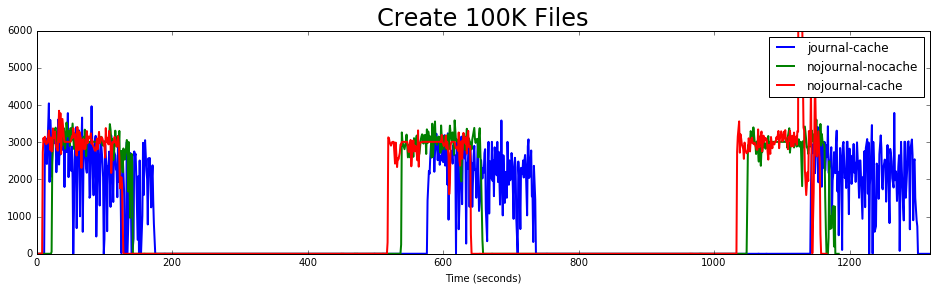

In [13]:
# plot entire run; input is (name, drop rows, ax)
fig0, ax0 = plt.subplots(1, 1, figsize=(16, 4))
for site in [("journal-cache", 75, 3),
             ("nojournal-nocache", 75, 1),
             ("nojournal-cache", 575, 2),
             ]:
    s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    metric = "handle_client_request_tput"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax0, x='x', y=metric, label=site[0], lw=2)
ax0.set_title('Create 100K Files', fontsize=24)
ax0.set_xlabel('Time (seconds)')
ax0.legend(loc='upper right')
ax0.set_ylim(0, 6000)

# Let's Zoom in on the cache

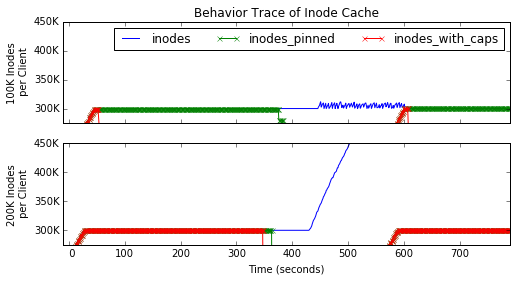

In [14]:
site = 'experiments/kernel/journal/results-done/journal-nocache/'
xlim = (490, 1290)
init = float("inf")

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
for m in ["inodes", "inodes_pinned", "inodes_with_caps"]:
    
    # input is array of tuples, where first is metric and second is which graph to put it on
    df = pd.read_csv(site + m + '.wsp.out', skiprows=13, names=["index", "time", m])
    
    # filter out null timestamps and shift time series
    df = df[df['time'] != 0]
    if m == "inodes": init = float(df['time'].loc[0])
    df['x'] = df['time'] - init
    #df[m] = df[m]/1000
    if m != "inodes":
        df.plot(ax=ax[0], x='x', y=m, marker='x', markersize=5)
    else:
        df.plot(ax=ax[0], x='x', y=m)
    ax[0].set_xlim(xlim[0], xlim[1])
ax[0].legend(fontsize=12, ncol=3)
ax[0].set_ylim(275000, 450000)
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:3.0f}K'.format(x/1000) for x in vals])
ax[0].set_xticklabels([])
ax[0].set_xlabel("")
ax[0].set_ylabel("100K Inodes\n per Client")
ax[0].set_title("Behavior Trace of Inode Cache")

site = 'experiments/kernel/journal/results-done/journal-cache/'
for m in ["inodes", "inodes_pinned", "inodes_with_caps"]:
    
    # input is array of tuples, where first is metric and second is which graph to put it on
    df = pd.read_csv(site + m + '.wsp.out', skiprows=13, names=["index", "time", m])
    
    # filter out null timestamps and shift time series
    df = df[df['time'] != 0]
    if m == "inodes": init = float(df['time'].loc[0])
    df['x'] = df['time'] - init
    if m != "inodes":
        df.plot(ax=ax[1], x='x', y=m, marker='x', markersize=5)
    else:
        df.plot(ax=ax[1], x='x', y=m)
    ax[1].set_xlim(690, 1490)
ax[1].set_ylim(275000, 450000)
ax[1].legend().remove()
vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:3.0f}K'.format(x/1000) for x in vals])
vals = ax[1].get_xticks()
ax[1].set_xticklabels(['{:3.0f}'.format(x-700) for x in vals])
ax[1].set_ylabel("200K Inodes\n per Client")
ax[1].set_xlabel("Time (seconds)")
fig.savefig('paper/graphs/behavior-cache.png', dpi=400)

# What is the effect of segment size?

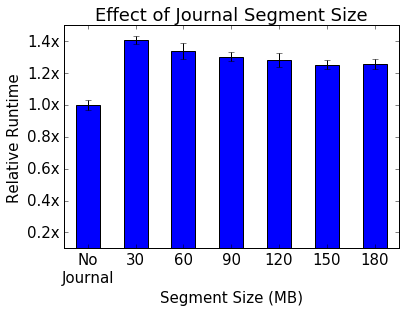

In [22]:
# baseline: creates without journal
df = pd.DataFrame(columns=["job", "mean", "std"])
s = "experiments/kernel/journal/results-done/nojournal-cache/"
d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
mean = np.mean(d)
d = d/mean
df.loc[len(df)] = ['No\nJournal', np.mean(d), np.std(d)]

# data: get normalized values
for site in ["30", "60", "90", "120", "150", "180"]:
    s = 'experiments/kernel/journal/results/journal' + site + '-cache/'
    d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
    d = d/mean
    df.loc[len(df)] = [site.replace('-', '\n'), np.mean(d), np.std(d)]
df

# plot
fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, y='mean', yerr='std')
ax.set_xticklabels(df['job'], rotation=0)
ax.legend().remove()
ax.set_title("Effect of Journal Segment Size")
ax.set_ylabel("Relative Runtime")
ax.set_ylim(0, 1.5)
ax.set_xlabel("Segment Size (MB)")
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}x'.format(x) for x in vals])
ax.set_ylim(0.1)

font = {'size'   : 15}
matplotlib.rc('font', **font)

df
fig.savefig('paper/graphs/slowdown-journal.png', dpi=400)

# How does the journal change behavior?

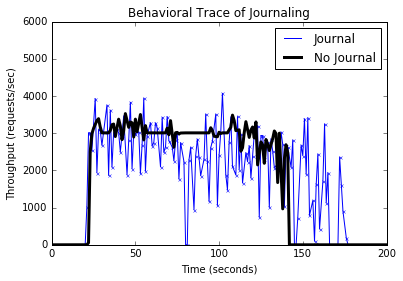

In [16]:
# plot 180 segments
site = "journal180-cache"
s = 'experiments/kernel/journal/results/' + site + '/'
metric = "handle_client_request_tput"
df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
df = df[df['time'] != 0]                  # filter out null timestamps
init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
df = df.drop(df.index[range(0, 75)])      # drop some values to line up start times
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
fig, ax = plt.subplots(1, 1)
df.plot(ax=ax, x='x', y=metric, lw=1, marker='x', markersize=3, label="Journal")

# plot no journal
site = "nojournal-nocache"
s = 'experiments/kernel/journal/results-done/' + site + '/'
metric = "handle_client_request_tput"
df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
df = df[df['time'] != 0]                  # filter out null timestamps
init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
df = df.drop(df.index[range(0, 75)])      # drop some values to line up start times
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
df.plot(ax=ax, x='x', y=metric, color='black', lw=3, markersize=0, label="No Journal")

ax.set_xlim(0, 200)
ax.set_ylim(0, 6000)
ax.set_ylabel("Throughput (requests/sec)")
ax.set_title("Behavioral Trace of Journaling")
ax.set_xlabel('Time (seconds)')
fig.savefig('paper/graphs/behavior-journal.png', dpi=400)

# What is the effect of caching?

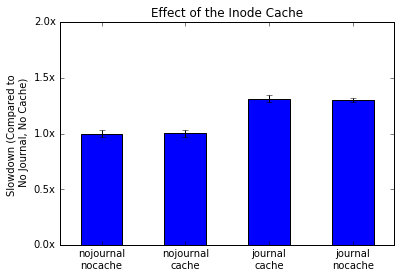

In [17]:
# baseline: no journal and no cache
s = 'experiments/kernel/journal/results-done/nojournal-nocache/'
d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
norm = np.mean(d)

df = pd.DataFrame(columns=["job", "mean", "std"])
for site in ["nojournal-nocache",
             "nojournal-cache",
             "journal-cache", 
             "journal-nocache"]:
    s = 'experiments/kernel/journal/results-done/' + site + '/'
    d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
    d = d/norm
    df.loc[len(df)] = [site.replace('-', '\n'), np.mean(d), np.std(d)]

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, y='mean', yerr='std')
ax.set_xticklabels(df['job'], rotation=0)
ax.set_title("Effect of the Inode Cache")
ax.legend().remove()
ax.set_ylabel("Slowdown (Compared to \n No Journal, No Cache)")
df
ax.set_ylim(0, 2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}x'.format(x) for x in vals])
fig.savefig('paper/graphs/slowdown-cache.png', dpi=400)